# Lab 4, Zad 3
## Sudoku

Celem ćwiczenia jest analiza metody wyżarzania zastosowanej do funkcji kosztu o bardziej dyskretnym charakterze.

### Import potrzebnych bibliotek

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import copy

Wczytywanie sudoku z pliku

Funckja `read_sudoku_from_files(input_file)` służy do wczytywania sudoku z pliku. Funkcja zwraca sudoku w postaci dwuwymiarowej listy oraz liczbę pustych pul

In [221]:
def read_sudoku_from_files(input_file):
    M = np.zeros((9,9))
    holes = 0
    # Otwieramy plik do odczytu
    with open(input_file, 'r') as file:
        # Przechodzimy po każdej linii w pliku
        for idx, line in enumerate(file):
            i=0
            for chr in line[:-1]:
                if chr=="x":
                    M[idx][i] == 0
                    holes += 1
                else:
                    M[idx][i%9] = ord(chr)-ord("0")
                i+=1
                if i==9: break

    return M, holes


# Rozwiązanie

Funkcja `fill_sudoku(sudoku)` uzupełnia puste pola w sudoku bazując na wierszy. Dla każdego wiersza funkcja wylicza liste brakujących cyfr w tym wierszu i losowo to uzupełnia 

In [222]:
def fill_sudoku_row(sudoku):
    n = len(sudoku)
    set_all = {1,2,3,4,5,6,7,8,9}
    empty_cells = [[] for _ in range(9)]
    for i in range(n):
        set_num_rows = set()
        for j in range(n):
            set_num_rows.add(sudoku[i][j])
        rest = set_all - set_num_rows
        j=0
        for r in rest:
            while sudoku[i][j] != 0:
                j+=1
                
            sudoku[i][j] =r
            empty_cells[i].append(j)
    return sudoku, empty_cells

Funkcja `count_errors(sudoku)` jest naszą funkcją błędu do zooptymalizowania. Dla kazego kwadratu 3x3, wiersza i kolumny sumuje liczbe konfliktów w ustwaieniu cyfr. Fucnkja zwraca całkowitą sumę błędu. 

In [223]:
def count_errors(sudoku):
    # wiersze
    n = len(sudoku)
    set_all = {1,2,3,4,5,6,7,8,9}
    cnt_errors = 0
    for i in range(n):
        set_num_cols = set()
        set_num_rows = set()
        set_num_sqr = set()
        for j in range(n):
            set_num_cols.add(sudoku[i][j])
            set_num_rows.add(sudoku[j][i])
            set_num_sqr.add(sudoku[i%3 *3 + j%3 ][i//3 *3 + j//3])
        cnt_errors += len(set_all-set_num_cols)
        cnt_errors += len(set_all - set_num_rows)
        cnt_errors += len(set_all - set_num_sqr)
    return cnt_errors


Funkcja `calc_diff(sudoku, x1, y1, x2, y2)` oblicza zmianę liczby błędów w planszy Sudoku po zamianie wartości w komórkach (x1, y1) oraz (x2, y2). Zwracana różnica to liczba błędów po zamianie minus liczba błędów przed zamianą.

In [224]:
def calc_diff(sudoku, x1, y1, x2, y2):
   # Funkcja oblicza różnicę w liczbie błędów po zamianie dwóch pól
   n = len(sudoku)
   
   # Pobieramy wartości z zamienianych pól
   val1 = int(sudoku[x1][y1])
   val2 = int(sudoku[x2][y2])
   
   # Jeśli wartości są takie same, nie ma sensu ich zamieniać
   if val1 == val2:
       return 0
       
   difference = 0
   
   # Kolumna y1
   col_values_y1 = [0] * 10  # Liczymy wystąpienia każdej cyfry w kolumnie y1
   for i in range(n):
       if sudoku[i][y1] > 0:  # Pomijamy puste pola oznaczone jako 0 lub -1
           col_values_y1[int(sudoku[i][y1])] += 1
           
   # Kolumna y2
   col_values_y2 = [0] * 10  # Liczymy wystąpienia każdej cyfry w kolumnie y2
   for i in range(n):
       if sudoku[i][y2] > 0:  # Pomijamy puste pola
           col_values_y2[int(sudoku[i][y2])] += 1
   
   # Kary przed zamianą
   difference -= 1 if col_values_y1[val1] > 1 else 0  # Kara za duplikat val1 w kolumnie y1
   difference -= 1 if col_values_y2[val2] > 1 else 0  # Kara za duplikat val2 w kolumnie y2
   
   # Symulujemy zamianę w kolumnach
   col_values_y1[val1] -= 1
   col_values_y1[val2] += 1
   col_values_y2[val2] -= 1
   col_values_y2[val1] += 1
   
   # Kary po zamianie
   difference += 1 if col_values_y1[val2] > 1 else 0  # Kara za duplikat val2 w kolumnie y1
   difference += 1 if col_values_y2[val1] > 1 else 0  # Kara za duplikat val1 w kolumnie y2
   
   # Sprawdzamy zmiany w kwadratach 3x3
   box1_row, box1_col = (x1 // 3) * 3, (y1 // 3) * 3
   box2_row, box2_col = (x2 // 3) * 3, (y2 // 3) * 3
   
   # Jeśli pola należą do różnych kwadratów 3x3
   if box1_row != box2_row or box1_col != box2_col:
       # Kwadrat 1
       box1_values = [0] * 10
       for r in range(3):
           for c in range(3):
               if int(sudoku[box1_row + r][box1_col + c]) > 0:
                   box1_values[int(sudoku[box1_row + r][box1_col + c])] += 1
                   
       # Kwadrat 2
       box2_values = [0] * 10
       for r in range(3):
           for c in range(3):
               if int(sudoku[box2_row + r][box2_col + c]) > 0:
                   box2_values[int(sudoku[box2_row + r][box2_col + c])] += 1
       
       # Kary przed zamianą w kwadratach
       difference -= 1 if box1_values[val1] > 1 else 0  # Kara za duplikat val1 w kwadracie 1
       difference -= 1 if box2_values[val2] > 1 else 0  # Kara za duplikat val2 w kwadracie 2
       
       # Symulujemy zamianę w kwadratach
       box1_values[val1] -= 1
       box1_values[val2] += 1
       box2_values[val2] -= 1
       box2_values[val1] += 1
       
       # Kary po zamianie w kwadratach
       difference += 1 if box1_values[val2] > 1 else 0  # Kara za duplikat val2 w kwadracie 1
       difference += 1 if box2_values[val1] > 1 else 0  # Kara za duplikat val1 w kwadracie 2
   
   return difference

Funkcja `propability(diffrance, Temp)` jest dokładnie taka sama jak w zadaniu pierwszym. Na podstawie różnicy energii oraz temperatury zwraca prawdopodobieństwo nieoptymalnej zmiany indeksów.

In [225]:
def propability(diffrance, temp):
    if diffrance < 0:
        return 1
    return np.exp(-diffrance/ temp)

Poniższe funkcje zmiany temperatury są takie same jak w zadaniu 1. Przetestowałem je, aby sprawdzić, która z nich — przy odpowiednio dobranych parametrach — pozwala algorytmowi wyżarzania najlepiej poradzić sobie z tym problemem.

In [226]:
def update_temp_geo(Temp, a, k ,temp_start):
    return a * Temp

def update_temp_linear(Temp, a, k ,temp_start):
    return max(Temp - a, 0.000001)
def update_temp_log(Temp, a, k ,temp_start):
    return temp_start / np.log(1 + k+1)

Główną funkcja jest `solve_sudoku()` Przyjmuje parametry:
- sudoku - tablica dwuwymiarowa reprezentująca sudoku
- temp_start - temperatura początkowa
- min_heat - minimalna temperatura, żeby kontynuować algorytm
- fun_change_par - parametr do funkcji spadku temperatury   
- fun_temp_change - funkcja spadku temperatury

Nowy stan generuję poprzez zamianę dwóch liczb **w tym samym wierszu**. Dzięki początkowemu wypełnieniu macierzy zgodnie z poprawnymi wierszami, zwiększam prawdopodobieństwo znalezienia lepszego rozwiązania poprzez ograniczenie przestrzeni przeszukiwań.

Funkcja zwraca wypełnione sudoku, tablice historii zmian funkcji optymalizowanej oraz liczbe błędów w wyznaczonym rozwiązaniu

In [227]:
def solve_sudoku(sudoku,
          temp_start,
          loop_limit,
          min_heat=1e-10,
          fun_change_par=0.999999,
          fun_temp_change=update_temp_geo):
    
    sudoku, empty_cells = fill_sudoku_row(sudoku) 
    temp = temp_start
    best_val = count_errors(sudoku)  # Początkowy błąd
    prev_val = best_val # Najlepsze rozwiązanie
    error_tab = [best_val]  # Historia błędów
    for i in range(loop_limit):
        if temp < min_heat:
            # Zatrzymanie, gdy temperatura osiągnie minimalny próg
            break
        
        raw_random = np.random.randint(0,9)
        while len(empty_cells[raw_random])<2:
            raw_random = np.random.randint(0,9)
        j_swap1, j_swap2 = random.sample(empty_cells[raw_random],2)
        
        # Zamiana elementów
        diff = calc_diff(sudoku, raw_random, j_swap1, raw_random, j_swap2)
        new_val = prev_val + diff

        # Akceptacja nowego rozwiązania na podstawie prawdopodobieństwa
        if np.random.uniform(0, 1) < propability(new_val - prev_val, temp):
            if new_val < best_val :
                best_val = new_val
            prev_val = new_val
            sudoku[raw_random, j_swap1], sudoku[raw_random, j_swap2] = sudoku[raw_random, j_swap2], sudoku[raw_random, j_swap1]
        error_tab.append(prev_val)
        if prev_val ==0 : break
        # Aktualizacja temperatury
        temp = fun_temp_change(temp, fun_change_par, i, temp_start)

    return sudoku, error_tab, best_val


Funckja `solve` przyjmuje identyczne parametry co funkcja solve_sudoku. Jej działanie polega na parukrotnym uruchomieniu przeszukiwania, jeżeli poprzednie zakończyło się nieznalezieniem optymalnego rozwiązania

In [ ]:
def solve(sudoku,
          temp_start,
          loop_limit,
          min_heat=1e-10,
          fun_change_par=0.999999,
          fun_temp_change=update_temp_geo,
          max_main_iter = 5):
    for i in range(max_main_iter):
        res,error_tab,final_error = solve_sudoku(copy.deepcopy(sudoku),
          temp_start,
          loop_limit,
          min_heat,
          fun_change_par,
          fun_temp_change,)
        
        if final_error == 0:
            return res,error_tab,final_error, i+1
    return res,error_tab,final_error, max_main_iter

# Funkcje pomocnicze

Dla lepszego zwizualizowania działania algorytmu zostały napisane:

Funkcja save_linear_plot(errors_tab, file_name) służy do zapisywania wykresu funkcji zmiany funkcji optymalizującej

In [229]:
def save_linear_plot(errors_tab, file_name='plot.png',path = ''):
    # Tworzymy nową figurę, ale nie rysujemy jej
    plt.figure()
    
    plt.title(f"Wykres funkcji liczby błędów dla {file_name}")
    plt.xlabel('Liczba iteracji')
    plt.ylabel('Liczba błędów')
    
    # Rysowanie wykresu - ale nie pokazujemy go na ekranie
    plt.plot(errors_tab)
    
    # Zapisz wykres do pliku (np. PNG)
    plt.savefig(f"{path}/{file_name}.png")
    
    # Zamykamy figurę, aby zapobiec wyświetlaniu wykresu w notebooku
    plt.close()

Funckja `save_matrix_to_file(matrix, filename)` zapisuje wynik algorytmu do pliku

In [230]:
def save_matrix_to_file(matrix, filename):

    with open(filename, 'w') as file:
        for row in matrix:
            line = ''.join(str(int(x)) for x in row)
            file.write(line + '\n')

# Test algorytmu

Do szybkiego przetestowania algorytmów dla przygotowanych zbiorach danych napisałem funkcje `test_sudoku`, która przyjmuje ścieżke ścieżke do plików sudoku `path` oraz liczbe sudoku w pliku `N`.

In [231]:
def test_sudoku(path, N, draw_plot):
    # Tworzymy pusty DataFrame, który będzie przechowywał wyniki
    df = pd.DataFrame()
    final_errors = []
    missing_places = []
    num_operations = []
    for i in range(1, N+1):
        # Wczytanie sudoku z pliku
        file_name = f"sudoku_{i}"
        easy_sudoku, holes = read_sudoku_from_files(f"{path}/sudoku/{file_name}.txt")

        # Rozwiązanie sudoku (zaktualizuj odpowiednie funkcje rozwiązujące)
        solved_sudoku,error_tab,final_error, attempts_number = solve(easy_sudoku, 4, 500000, fun_temp_change=update_temp_geo, fun_change_par=0.999993)

        save_matrix_to_file(solved_sudoku, f"{path}/sudoku_result/{file_name}.txt")
        
        
        save_linear_plot(error_tab, file_name, f"{path}/figs")
        
        final_errors.append(final_error)
        # Zapisujemy dane do DataFrame
        new_row = pd.DataFrame({
            "nazwa pliku": [file_name],  # Nazwa pliku
            "liczba błędów": [final_error],  # Liczba błędów
            "liczba operacji": [len(error_tab)],
            "Początkowa liczba brakujących miejsc": holes,
            "Liczba prób": attempts_number# Liczba iteracji (długość tablicy t)
        })

        # Łączenie DataFrame
        df = pd.concat([df, new_row], ignore_index=True)
        missing_places.append(holes)
        num_operations.append(len(error_tab))
        # Rysowanie wykresu
    if draw_plot:
        plt.figure()
        plt.scatter(missing_places, num_operations, color='blue')
        plt.title("Liczba iteracji w zależności od liczby brakujących miejsc")
        plt.xlabel("Liczba brakujących miejsc")
        plt.ylabel("Liczba iteracji")
        plt.grid(True)

    return df


## Testy generowane

Do przetestowania algorytmu użyłem generatora losowych sudoku o zadanej liczbie pustych pul. Są one zapisane w odpowiednich katalogach w folderze zad3_sudoku

### Sudoku z 35 wolnymi miejscami

In [201]:
test_sudoku("zad3_sudoku/empty_35",20, False)

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,0,68297,34,1
1,sudoku_2,0,64516,35,1
2,sudoku_3,0,54519,35,1
3,sudoku_4,0,42661,34,1
4,sudoku_5,0,66786,35,1
5,sudoku_6,0,51422,34,1
6,sudoku_7,0,50893,34,1
7,sudoku_8,0,49791,35,1
8,sudoku_9,0,62199,34,1
9,sudoku_10,0,63873,34,1


Dla relatywnie małej liczby brakujących miejsc algorytm poradził sobie bardzo dobrze. Do wyniku dotarł w zadowalającej liczbie operacji bez ugrząźnięcia w minimum lokalnym

### Sudoku z 45 wolnymi miejscami

In [203]:
test_sudoku("zad3_sudoku/empty_45",20, False)

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,0,212421,44,1
1,sudoku_2,0,178546,44,1
2,sudoku_3,0,168556,44,1
3,sudoku_4,0,195680,45,1
4,sudoku_5,0,173395,44,1
5,sudoku_6,0,183813,45,1
6,sudoku_7,0,166921,44,1
7,sudoku_8,0,156652,44,1
8,sudoku_9,0,195071,44,1
9,sudoku_10,0,190781,44,2


Podobnie jak w przypadku sudoku z 35 pustymi polami, algorytm skutecznie odnalazł poprawne rozwiązanie. Należy jednak zaznaczyć duży wzrost liczby wykonanych operacji (prawie 3 krotny). Dodatkowo, w jednej z prób konieczne okazało się ponowne przeliczenie planszy, gdyż pierwsze podejście nie przyniosło oczekiwanego rezultatu.

### Sudoku z 55 wolnymi miejscami

In [205]:
test_sudoku("zad3_sudoku/empty_55",20, False)

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,0,204106,54,3
1,sudoku_2,0,169948,54,1
2,sudoku_3,0,190734,54,3
3,sudoku_4,0,211471,55,1
4,sudoku_5,0,230485,54,2
5,sudoku_6,0,199300,55,1
6,sudoku_7,0,208007,54,1
7,sudoku_8,0,178702,54,1
8,sudoku_9,0,200982,55,3
9,sudoku_10,0,199865,54,1


W niektórych przypadkach algorytm musiał zostać uruchomiony nawet trzykrotnie, aby znaleźć poprawne rozwiązanie. Zaobserwowano niewielki wzrost liczby operacji, jednak nie był on znaczący. Ostatecznie algorytm znalazł poprawne rozwiązanie we wszystkich testowanych przypadkach.

### Sudoku z 65 wolnymi miejscami

In [232]:
test_sudoku("zad3_sudoku/empty_65",20, False)

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,0,288022,65,1
1,sudoku_2,0,307510,65,1
2,sudoku_3,0,316653,64,1
3,sudoku_4,0,307608,64,1
4,sudoku_5,0,294140,64,1
5,sudoku_6,0,311770,65,1
6,sudoku_7,0,273530,64,1
7,sudoku_8,0,300860,64,1
8,sudoku_9,0,277212,64,1
9,sudoku_10,0,334563,64,1


Zaobserwowano poprawę liczby wykonanych prób przez algorytm w porównaniu do sudoku z 55 wolnymi polami. Wynika to z faktu, że po przekroczeniu pewnego progu zwiększanie liczby pustych miejsc istotnie powiększa zbiór poprawnych kombinacji ułożeń liczbowych. Choć całkowita liczba możliwych kombinacji rośnie, to wzrasta również liczba rozwiązań spełniających warunki sudoku – dzięki temu algorytm wykazuje wyższą skuteczność.

### Sudoku z 75 wolnymi miejscami

In [218]:
test_sudoku("zad3_sudoku/empty_75",20, False)

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,0,317715,74,1
1,sudoku_2,0,308594,74,1
2,sudoku_3,0,306742,74,1
3,sudoku_4,0,296661,74,1
4,sudoku_5,0,287293,74,1
5,sudoku_6,0,310890,74,1
6,sudoku_7,0,300129,74,1
7,sudoku_8,0,297703,74,1
8,sudoku_9,0,301889,74,1
9,sudoku_10,0,309909,74,1


Ten przykład wyraźnie potwierdza wcześniejsze obserwacje. Zwiększenie liczby pustych pól skutkuje znacznym wzrostem liczby poprawnych rozwiązań sudoku, co w tym przypadku przełożyło się na stosunkowo szybkie i precyzyjne znalezienie odpowiedniego ułożenia. Jedynie w jednym przypadku konieczne okazało się powtórzenie obliczeń.

Podsumowanie: Algorytm poradził sobie bardzo dobrze w przypadku losowo wygenerowanych plansz Sudoku. Dla wszystkich testowanych przypadków udało się znaleźć poprawne rozwiązanie, bez wystąpienia błędów.

## Test na trudnym sudoku 

Z zasobów internetowych<sup>[1]</sup> pozyskałem zestaw wymagających łamigłówek Sudoku, które umieściłem w katalogu „hard”. Stanowią one solidny materiał testowy do oceny skuteczności opracowanego algorytmu. Przeanalizujmy jego działanie na tym właśnie zbiorze.

,nazwa pliku,liczba błędów,liczba operacji,Początkowa liczba brakujących miejsc,Liczba prób
0,sudoku_1,2,500001,53,5
1,sudoku_2,0,296126,55,4
2,sudoku_3,0,259118,49,1
3,sudoku_4,0,308385,53,2
4,sudoku_5,2,500001,55,5
5,sudoku_6,0,330624,49,1
6,sudoku_7,0,370646,52,1
7,sudoku_8,3,500001,55,5
8,sudoku_9,0,360963,56,4
9,sudoku_10,0,294135,53,2


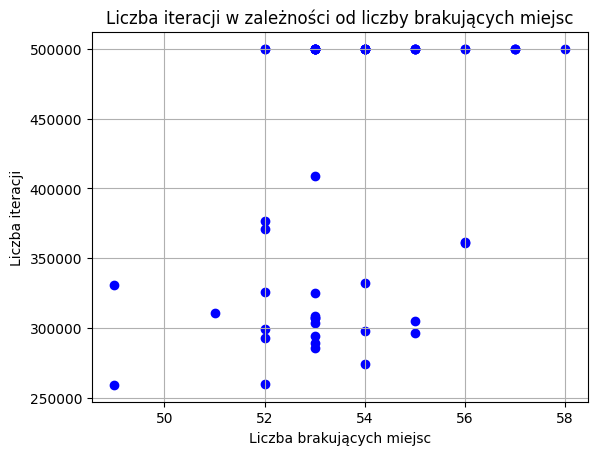

In [217]:
test_sudoku("zad3_sudoku/hard",50, True)

Jak pokazują wyniki, w 24 przypadkach algorytm nie zdołał znaleźć poprawnego rozwiązania, mimo pięciokrotnej próby jego wyznaczenia. Przyczyną może być bardzo ograniczony zbiór poprawnych rozwiązań dla tych łamigłówek, który w niektórych przypadkach może wynosić tylko jedno możliwe rozwiązanie. W takim scenariuszu nasz algorytm może napotkać trudności, gdyż nie znajduje wystarczającej przestrzeni do przeprowadzenia optymalizacji funkcji kosztu za pomocą metod opartych na gradiencie.

Liczba operacji wykazywała dużą zmienność w zależności od liczby pustych pól. Na podstawie przeprowadzonych obserwacji trudno jest jednak dostrzec jednoznaczną zależność pomiędzy tymi zmiennymi.

# Podsumowanie


Przeprowadzone testy wykazały, że algorytm wyżarzania jest skuteczny w przypadku losowych łamigłówek sudoku. Jednak w trudniejszych przypadkach, gdzie liczba poprawnych rozwiązań jest ograniczona, funkcja nie jest w stanie znaleźć właściwego rozwiązania, pomimo wielokrotnych prób.

Trudno jest wywnioskować jednoznaczną zależność pomiędzy liczbą operacji a liczbą pustych pól w macierzy. Tabele z wynikami testów dla sudoku o podobnej liczbie brakujących elementów wykazały znaczne wahania, co podkreśla, że liczba operacji zależy w dużym stopniu od specyfiki poszczególnych przypadków.

Algorytm wyżarzania okazuje się niewłaściwym narzędziem do rozwiązywania tego typu problemów. Ze względu na dyskretną naturę funkcji kosztu, trudności w przechodzeniu między stanami stają się wyraźnie widoczne. Dodatkowo, charakterystyka algorytmu, który dąży raczej do znalezienia przybliżonego rozwiązania niż dokładnego, sprawia, że wynik uzyskany przez ten algorytm jest błędny w kontekście postawionego zadania.

# Bibliografia

[1] Hard Sudoku - https://raw.githubusercontent.com/grantm/sudoku-exchange-puzzle-bank/refs/heads/master/diabolical.txt